In [1]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from skimage.util import random_noise
from scipy.ndimage import gaussian_filter, map_coordinates

# Loading dataset

In [2]:
dataset_path = "/kaggle/input/skin-disease-image-dataset-balanced/Split_smol"

In [3]:
def load_images_from_directory(base_path):
    image_data = {}

    for split in ['train', 'val']:
        split_path = os.path.join(base_path, split)
        if not os.path.exists(split_path):
            continue

        for category in os.listdir(split_path):
            category_path = os.path.join(split_path, category)
            if not os.path.isdir(category_path):
                continue
            
            if category not in image_data:
                image_data[category] = []

            for file in os.listdir(category_path):
                file_path = os.path.join(category_path, file)
                img = cv2.imread(file_path)
                if img is not None:
                    image_data[category].append(img)

    for category, images in image_data.items():
        print(f"{category}: {len(images)} images loaded")

    return image_data

In [4]:
data = load_images_from_directory(dataset_path)

Melanoma: 291 images loaded
Vascular lesion: 252 images loaded
Melanocytic nevus: 273 images loaded
Actinic keratosis: 280 images loaded
Squamous cell carcinoma: 328 images loaded
Benign keratosis: 346 images loaded
Basal cell carcinoma: 300 images loaded
Dermatofibroma: 238 images loaded


# Applying data augmentation

In [5]:
def random_rotation(image):
    angle = random.uniform(-30, 30)
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    return cv2.warpAffine(image, M, (w, h))

def random_flip(image):
    flip_type = random.choice([-1, 0, 1])
    return cv2.flip(image, flip_type)

def random_brightness_contrast(image):
    brightness = random.uniform(0.7, 1.3) 
    contrast = random.uniform(0.7, 1.3)  
    img = np.clip(image * contrast + brightness, 0, 255).astype(np.uint8)
    return img

def random_zoom(image, zoom_range=(0.8, 1.2)):
    h, w = image.shape[:2]
    scale = random.uniform(zoom_range[0], zoom_range[1])
    nh, nw = int(h * scale), int(w * scale)
    resized = cv2.resize(image, (nw, nh))

    if scale < 1:  
        pad_h, pad_w = (h - nh) // 2, (w - nw) // 2
        return cv2.copyMakeBorder(resized, pad_h, pad_h, pad_w, pad_w, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    else:
        start_h, start_w = (nh - h) // 2, (nw - w) // 2
        return resized[start_h:start_h + h, start_w:start_w + w]

def augment_image(image):
    aug1 = random_rotation(image)
    aug2 = random_flip(image)
    aug3 = random_brightness_contrast(image)
    aug4 = random_zoom(image)
    
    return [aug1, aug2, aug3, aug4]

In [6]:
for category, imgs in list(data.items()):
    augmented_images = []
    
    for img in imgs:
        augmented_images.extend(augment_image(img))
    
    data[category].extend(augmented_images)

In [7]:
# Images after augmentation
for category, imgs in data.items():
    print(f"{category}: {len(imgs)} images loaded")

Melanoma: 1455 images loaded
Vascular lesion: 1260 images loaded
Melanocytic nevus: 1365 images loaded
Actinic keratosis: 1400 images loaded
Squamous cell carcinoma: 1640 images loaded
Benign keratosis: 1730 images loaded
Basal cell carcinoma: 1500 images loaded
Dermatofibroma: 1190 images loaded


In [8]:
# Augmenting minority classes
for category, imgs in data.items():
    num_images = len(imgs)
    max_images = 1730 

    augmented_imgs = []
    while len(imgs) + len(augmented_imgs) < max_images:
        img = random.choice(imgs)
        augmented_imgs.extend(augment_image(img))

    data[category] = imgs + augmented_imgs[:max_images - num_images]

In [9]:
# Images after augmentating minority classess
for category, imgs in data.items():
    print(f"{category}: {len(imgs)} images loaded")

Melanoma: 1730 images loaded
Vascular lesion: 1730 images loaded
Melanocytic nevus: 1730 images loaded
Actinic keratosis: 1730 images loaded
Squamous cell carcinoma: 1730 images loaded
Benign keratosis: 1730 images loaded
Basal cell carcinoma: 1730 images loaded
Dermatofibroma: 1730 images loaded


# Visualizing images

In [10]:
def show_images(data):
    for category, imgs in data.items():
        print(f"{category}: {len(imgs)} images loaded")

        sample_images = imgs[:3]  

        fig, axes = plt.subplots(1, 3, figsize=(10, 3))
        fig.suptitle(f"Images - {category}", fontsize=14)
        
        for i, img in enumerate(sample_images):
            axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[i].axis('off') 
        
        for i in range(len(sample_images), 3):
            axes[i].axis('off')

        plt.show()

Melanoma: 1730 images loaded


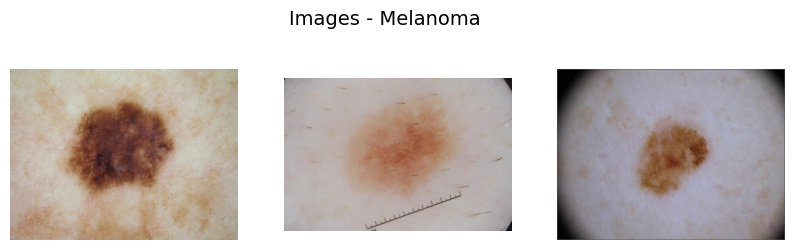

Vascular lesion: 1730 images loaded


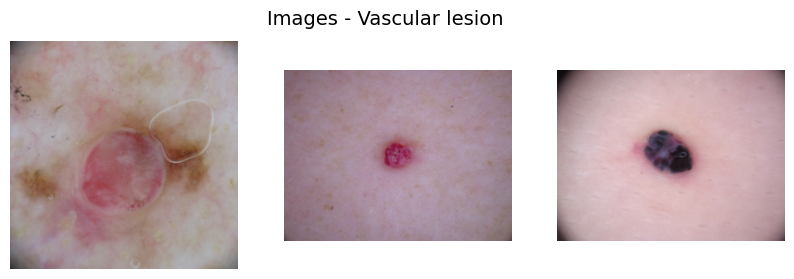

Melanocytic nevus: 1730 images loaded


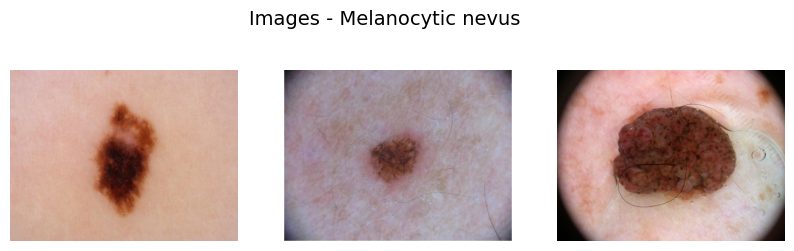

Actinic keratosis: 1730 images loaded


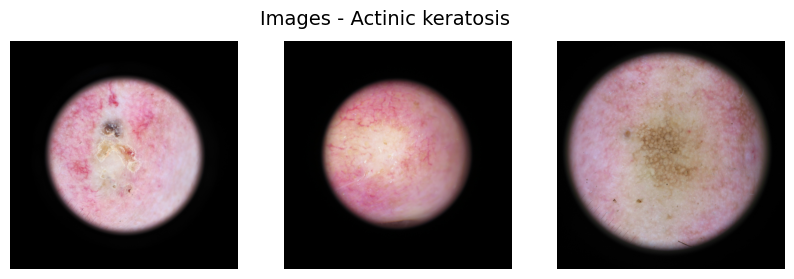

Squamous cell carcinoma: 1730 images loaded


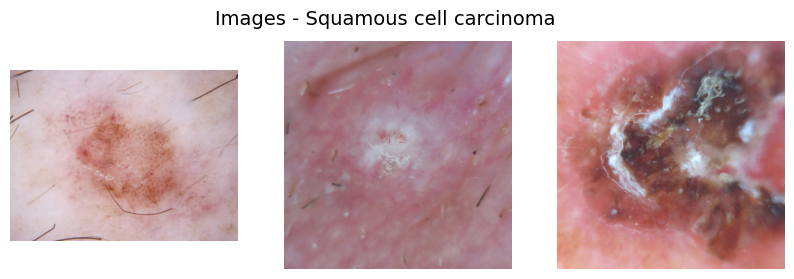

Benign keratosis: 1730 images loaded


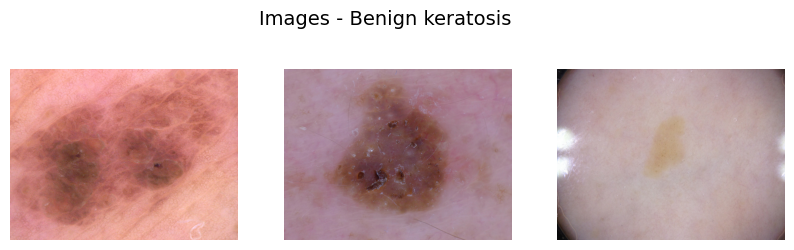

Basal cell carcinoma: 1730 images loaded


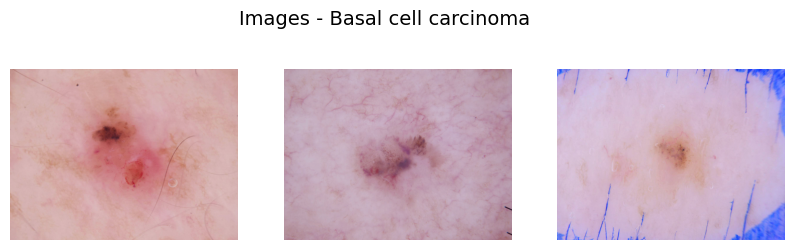

Dermatofibroma: 1730 images loaded


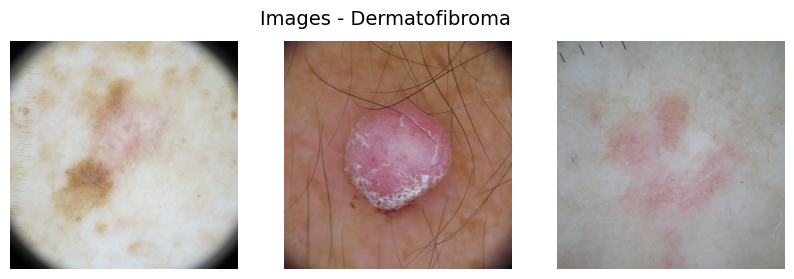

In [11]:
show_images(data)

# Preprocessing and Splitting Data

In [12]:
def split_data(data, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    train_data, val_data, test_data = {}, {}, {}

    for category, imgs in data.items():
        labels = [category] * len(imgs)
        train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(
            imgs, labels, test_size=(val_ratio + test_ratio), stratify=labels
        )
        val_imgs, test_imgs, val_labels, test_labels = train_test_split(
            temp_imgs, temp_labels, test_size=test_ratio / (val_ratio + test_ratio), stratify=temp_labels
        )

        train_data[category] = train_imgs
        val_data[category] = val_imgs
        test_data[category] = test_imgs

    return train_data, val_data, test_data

In [13]:
def preprocess_images(image_list, target_size=(64, 64)):
    processed_images = []
    
    for img in image_list:
        if not isinstance(img, np.ndarray):
            continue
        
        img = cv2.resize(img, target_size)
        
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        
        img = img.astype("float32") / 255.0
        
        processed_images.append(img)
    
    return np.array(processed_images)

def split_and_prepare_data(data):
    train_data, val_data, test_data = split_data(data, train_ratio=0.85, val_ratio=0.1, test_ratio=0.05)

    train_data = {label: preprocess_images(images) for label, images in train_data.items()}
    val_data = {label: preprocess_images(images) for label, images in val_data.items()}
    test_data = {label: preprocess_images(images) for label, images in test_data.items()}

    return train_data, val_data, test_data

In [14]:
train_data, val_data, test_data = split_and_prepare_data(data)

In [15]:
print("Dataset split summary:")

print("\nTraining set:")
for category, imgs in train_data.items():
    print(f"{category}: {len(imgs)} images")

print("\nValidation set:")
for category, imgs in val_data.items():
    print(f"{category}: {len(imgs)} images")

print("\nTest set:")
for category, imgs in test_data.items():
    print(f"{category}: {len(imgs)} images")

Dataset split summary:

Training set:
Melanoma: 1470 images
Vascular lesion: 1470 images
Melanocytic nevus: 1470 images
Actinic keratosis: 1470 images
Squamous cell carcinoma: 1470 images
Benign keratosis: 1470 images
Basal cell carcinoma: 1470 images
Dermatofibroma: 1470 images

Validation set:
Melanoma: 173 images
Vascular lesion: 173 images
Melanocytic nevus: 173 images
Actinic keratosis: 173 images
Squamous cell carcinoma: 173 images
Benign keratosis: 173 images
Basal cell carcinoma: 173 images
Dermatofibroma: 173 images

Test set:
Melanoma: 87 images
Vascular lesion: 87 images
Melanocytic nevus: 87 images
Actinic keratosis: 87 images
Squamous cell carcinoma: 87 images
Benign keratosis: 87 images
Basal cell carcinoma: 87 images
Dermatofibroma: 87 images


# Converting data to numpy arrays & labels

In [16]:
def prepare_data_dict(data_dict):
    X, y = [], []
    for category, images in data_dict.items():
        label = category_to_label[category]
        for img in images:
            X.append(img)  
            y.append(label)
    
    X = np.array(X)
    y = to_categorical(np.array(y), num_classes=num_classes)
    
    return X, y

In [17]:
categories = list(train_data.keys())
num_classes = len(categories)
category_to_label = {category: i for i, category in enumerate(categories)}

In [18]:
X_train, y_train = prepare_data_dict(train_data)
X_val, y_val = prepare_data_dict(val_data)
X_test, y_test = prepare_data_dict(test_data)

In [19]:
print(f"Train shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Val shape: {X_val.shape}, Labels shape: {y_val.shape}")
print(f"Test shape: {X_test.shape}, Labels shape: {y_test.shape}")

Train shape: (11760, 64, 64, 3), Labels shape: (11760, 8)
Val shape: (1384, 64, 64, 3), Labels shape: (1384, 8)
Test shape: (696, 64, 64, 3), Labels shape: (696, 8)


In [20]:
print(X_train[0])
print(y_train[0])

[[[0.3372549  0.2509804  0.1882353 ]
  [0.38431373 0.36862746 0.41568628]
  [0.4862745  0.45882353 0.4862745 ]
  ...
  [0.42745098 0.44705883 0.49803922]
  [0.4        0.4117647  0.4627451 ]
  [0.4117647  0.40784314 0.44705883]]

 [[0.53333336 0.41568628 0.3137255 ]
  [0.41960785 0.39607844 0.44313726]
  [0.5137255  0.49803922 0.5176471 ]
  ...
  [0.40784314 0.42745098 0.49019608]
  [0.39215687 0.40784314 0.4627451 ]
  [0.41960785 0.41568628 0.4509804 ]]

 [[0.5294118  0.49411765 0.49803922]
  [0.4862745  0.4627451  0.48235294]
  [0.4862745  0.47058824 0.5058824 ]
  ...
  [0.43529412 0.45490196 0.5019608 ]
  [0.42352942 0.45490196 0.5058824 ]
  [0.4745098  0.4745098  0.50980395]]

 ...

 [[0.0627451  0.05098039 0.05098039]
  [0.05098039 0.04705882 0.04705882]
  [0.4392157  0.4392157  0.4745098 ]
  ...
  [0.4627451  0.46666667 0.5058824 ]
  [0.5176471  0.49411765 0.52156866]
  [0.35686275 0.35686275 0.39607844]]

 [[0.05098039 0.04313726 0.04313726]
  [0.05490196 0.05098039 0.05098039]


# Building CNN

In [21]:
from tensorflow.keras import Sequential
import tensorflow.keras.layers as tfl

In [26]:
model = Sequential([
    tfl.Input(shape=(64, 64, 3)),
    
    tfl.Conv2D(32, 3, activation='relu', padding='same'),
    tfl.BatchNormalization(),
    tfl.MaxPooling2D((2, 2)),
    
    tfl.Conv2D(64, 3, activation='relu', padding='same'),
    tfl.BatchNormalization(),
    tfl.MaxPooling2D((2, 2)),
    
    tfl.Conv2D(128, 3, activation='relu', padding='same'),
    tfl.BatchNormalization(),
    tfl.Conv2D(128, 3, activation='relu', padding='same'),
    tfl.BatchNormalization(),
    tfl.MaxPooling2D((2, 2)),

    tfl.Conv2D(256, 3, activation='relu', padding='same'),
    tfl.BatchNormalization(),
    tfl.Conv2D(256, 3, activation='relu', padding='same'),
    tfl.BatchNormalization(),
    tfl.MaxPooling2D((2, 2)),

    tfl.Flatten(),
    
    tfl.Dense(128, activation='relu'),
    tfl.Dropout(0.3),

    tfl.Dense(64, activation='relu'),
    tfl.Dropout(0.3),

    tfl.Dense(num_classes, activation='softmax'),
])

In [27]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,662,728 (6.34 MB)

 Trainable params: 1,661,000 (6.34 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [30]:
epochs = 50

history = model.fit(X_train, y_train,
                   validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=32, 
                   )

Epoch 1/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.3426 - loss: 1.6986 - val_accuracy: 0.3382 - val_loss: 1.6288
Epoch 2/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.3845 - loss: 1.5650 - val_accuracy: 0.4328 - val_loss: 1.4545
Epoch 3/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4292 - loss: 1.4400 - val_accuracy: 0.4646 - val_loss: 1.3972
Epoch 4/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4764 - loss: 1.3390 - val_accuracy: 0.4335 - val_loss: 1.3592
Epoch 5/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5152 - loss: 1.2516 - val_accuracy: 0.4798 - val_loss: 1.3625
Epoch 6/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5514 - loss: 1.1685 - val_accuracy: 0.5759 - val_loss: 1.0911
Epoch 7/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5863 - loss: 1.1087 - val_accuracy: 0.5874 - val_loss: 1.0900
Epoch 8/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6240 - loss: 1.0053 - val_accu

In [31]:
eval_res = model.evaluate(X_test, y_test)
  
print(eval_res)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8576 - loss: 0.7352
[0.7743290066719055, 0.8548850417137146]


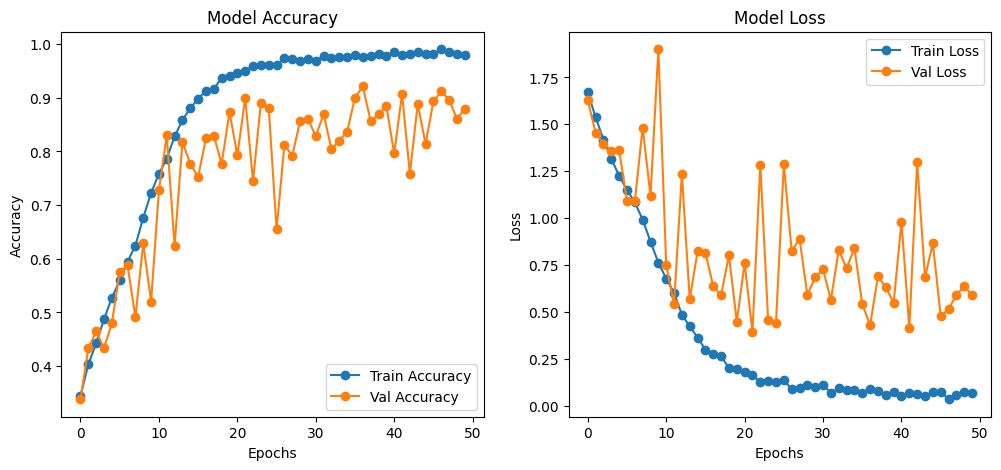

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
ax[0].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
ax[0].plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(history.history['loss'], label='Train Loss', marker='o')
ax[1].plot(history.history['val_loss'], label='Val Loss', marker='o')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.show()

In [33]:
from sklearn.metrics import classification_report

In [34]:
y_pred_probs = model.predict(X_test)

y_pred = np.argmax(y_pred_probs, axis=1)

if y_test.shape[-1] > 1:
    y_test_labels = np.argmax(y_test, axis=1) 
else:
    y_test_labels = y_test

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step 


In [35]:
class_names = [
    "Melanoma",
    "Vascular lesion",
    "Melanocytic nevus",
    "Actinic keratosis",
    "Squamous cell carcinoma",
    "Benign keratosis",
    "Basal cell carcinoma",
    "Dermatofibroma"
]

In [36]:
report = classification_report(y_test_labels, y_pred, target_names=class_names)
print(report)  

                         precision    recall  f1-score   support

               Melanoma       0.86      0.86      0.86        87
        Vascular lesion       1.00      0.82      0.90        87
      Melanocytic nevus       0.93      0.89      0.91        87
      Actinic keratosis       0.68      0.94      0.79        87
Squamous cell carcinoma       0.83      0.78      0.80        87
       Benign keratosis       0.86      0.89      0.87        87
   Basal cell carcinoma       0.89      0.80      0.84        87
         Dermatofibroma       0.90      0.86      0.88        87

               accuracy                           0.85       696
              macro avg       0.87      0.85      0.86       696
           weighted avg       0.87      0.85      0.86       696



In [38]:
from IPython.display import FileLink
model.save("/kaggle/working/skin_cancer_classifier_V1.h5")
FileLink("/kaggle/working/skin_cancer_classifier_V1.h5")

/kaggle/working/skin_cancer_classifier_V1.h5